## 1D horizontal poroelastic model

Here we consider a "thin aquifer" approximation where the 2D plane strain ($\epsilon_{zz} = \epsilon_{xz} = \epsilon_{yz} = 0$) poroelastic problem reduces to a 1D horizontal poroelastic problem.
Starting from the mechanical equations in plane strain in the absence of body forces: 
$$\frac{\partial\sigma_{xx}}{\partial x}+\frac{\partial\sigma_{xy}}{\partial y}=0$$
$$\frac{\partial\sigma_{xy}}{\partial x}+\frac{\partial\sigma_{yy}}{\partial y}=0$$
we can see that neglecting the depth-dependency of $\sigma_{xy}$ implies that $\partial\sigma_{xx}/\partial x = 0$. For stress-free lateral boundary conditions ($\sigma_{xx}$ = 0), $\sigma_{xx}$ must thus be equal to 0 everywhere. Similarly, neglecting the depth-dependency of $\sigma_{yy}$ implies that $\partial\sigma_{xy}/\partial x = 0$, which is consistent with free-slip boundary conditions ($\sigma_{xy} = 0$).

For the constitutive poroelastic equation:
$$\epsilon_{ij} = \frac{1}{2G}\left[\sigma_{ij}-\frac{\nu}{1+\nu}\sigma_{kk}\delta_{ij}+\frac{1-2\nu}{1+\nu}\alpha p\right]$$
The plane strain condition $\epsilon_{zz} = 0$ implies that: 
$$\sigma_{zz} = \nu(\sigma_{xx}+\sigma_{yy})-(1-2\nu)\alpha p$$

For $\sigma_{xx} = 0$, 
$$\sigma_{zz} = \nu\sigma_{yy}-(1-2\nu)\alpha p$$
such that volumetric stress $\sigma_{kk}$ and volumetric strain $\epsilon_{kk}$ reduce to functions of $\sigma_{yy}$ and $p$ only:
$$\sigma_{kk} = \sigma_{xx} + \sigma_{yy} + \sigma_{zz} = (1+\nu)\sigma_{yy}-(1-2\nu)\alpha p$$
$$\epsilon_{kk} = \frac{1-2\nu}{2G}(\sigma_{yy}+2\alpha p)$$
If we set $\sigma_{yy} = \sigma_{ice}$, then $\sigma_{kk}$ and $\epsilon_{kk}$ are fully known and the poroelastic diffusion equation: 
$$\alpha\frac{\partial \epsilon_{kk}}{\partial t} + S_\epsilon\frac{\partial p}{\partial t} = \frac{k}{\mu}\left(\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2}\right)$$

can be solved independently from the mechanical equations. Substituting $\epsilon_{kk}$ in the diffusion equation and neglecting the depth-dependency of pore pressure, consistent with no vertical flow boundary conditions ($\partial p/\partial y = 0$), yields: 
$$\frac{\alpha(1-2\nu)}{2G}\frac{\partial \sigma_{ice}}{\partial t} + \left(\frac{2\alpha^2(1-2\nu)}{2G}+S_\epsilon\right)\frac{\partial p}{\partial t}=\frac{k}{\mu}\frac{\partial^2 p}{\partial x^2}$$

Substituting $S_\epsilon = 3\alpha(1-2\nu_u)/(2BG(1+\nu_u))$: 
$$\frac{\partial \sigma_{ice}}{\partial t} + \frac{3}{B(1+\nu_u)}\frac{\partial p}{\partial t}=\frac{k}{\mu}\frac{2G}{\alpha (1-\nu)}\frac{\partial^2 p}{\partial x^2}$$

In the undrained limit, which applies at $t = 0^+$, the diffusion equation is dominated by the temporal derivatives such that:

$$\frac{\partial \sigma_{ice}}{\partial t} = -\frac{3}{B(1+\nu_u)}\frac{\partial p}{\partial t}$$
and 
$$p_{undrained} = -\frac{B(1+\nu_u)}{3}\sigma_{ice}$$ 
Moreover, in the incompressible constituents limit, $B = 1$, $\nu_u = 0.5$ and $p_{undrained} = -\sigma_{yy}/2$. 

We note that since the resulting poroelastic diffusion equation is essentially a 1D diffusion equation with a known internal source term, it is possible to find an analytical solution. Here we consider the numerical solution. We consider the initial condition p(x,t=0) = 0 (initially in steady state) and boundary conditions $\partial p/\partial x (x = 0,t)= 0$ on the left (for symmetry) and p(x=L,t) = 0 on the right to represent a free-draining surface. 

In [1]:
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'
rcParams['font.size'] = 13
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import numpy as np
from scipy.sparse.linalg import inv
from horizontal_diffusion import horizontal_diffusion

%matplotlib widget

0.493827160493827
(501, 150)


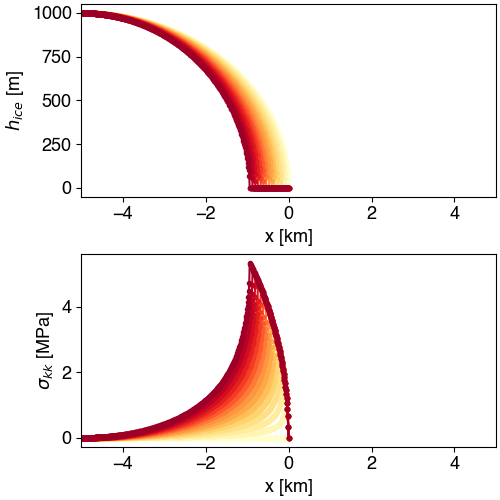

In [ ]:
# Poroelastic constants
G = 10e9 # Shear modulus [GPa]
nu = 0.25 # Drained Poisson's ratio
nu_u = 0.35 # Undrained Poisson's ratio
alpha = 0.9 # Biot coefficient
rho_w = 1000 # Reference water density [kg/m^3]
rho_i = 917 # Ice density [kg/m^3]
g = 10 # gravitational acceleration
k = 1e-13 # Aquifer permeability [m^2]
mu = 1e-3 # Dynamic viscosity of water [kg/(m·s)] 
c_m = alpha*(1-2*nu)/(2*(1-nu)*G) # Uniaxial poroelastic expansion coefficient
gamma = 1/alpha*(nu_u-nu)/((1-2*nu)*(1-nu_u)) #Loading efficiency
c = k*gamma/(mu*c_m) #hydraulic diffusivity [m^2/s]
B = 3*(nu_u-nu)/(alpha*(1-2*nu)*(1+nu_u)) # Skempton's coefficient
S = k/(mu*c) # Uniaxial specific storage

# Model parameters
L = 10000
dx = 10
#x = np.arange(-L/2,L/2+dx,dx) # x gridpoints
x = np.arange(-L/2,dx,dx) # x gridpoints
nx = len(x)

## Numerical parameters:
dt = 86400 # timestep [s] (1 day)
nt = 150 # Number of timesteps to compute (150 days)
times = np.arange(dt,(nt+1)*dt,dt) # Time array

## Growing ice sheet profile: 
retreat = 1000 # in meters
height_drop = 0 # in meters
L_max = L/2
H_max = 1000
L_ice = -retreat*times/(nt*dt)+L_max
H_ice = -height_drop*times/(nt*dt)+H_max
h_ice = np.zeros([nx,nt])

fig1, ax = plt.subplots(2,1,figsize = (5,5),constrained_layout=True)
cmap = plt.cm.YlOrRd
colors = cmap(np.linspace(0, 1, nt))
norm = mcolors.Normalize(vmin=0, vmax=times[-1]/3600/24)
sm = ScalarMappable(cmap='YlOrRd', norm=norm) 

for n in np.arange(0,nt):
    for i in np.arange(0,nx): 
        if (1-((x[i]+L/2)/(L_ice[n]))**2)>0:
            h_ice[i,n] = H_ice[n]*np.sqrt(1-((x[i]+L/2)/(L_ice[n]))**2)
    if n % 10 == 0:
        ax[0].plot(x/1e3,h_ice[:,n],'.-',color=colors[n])
        ax[0].set_xlabel('x [km]')
        ax[0].set_ylabel('$h_{ice}$ [m]')
        ax[0].set_xlim(-5,5)

        ax[1].plot(x/1e3,-rho_i*g*(h_ice[:,n]-h_ice[:,0])/1e6,'.-',color=colors[n])
        ax[1].set_xlabel('x [km]')
        ax[1].set_ylabel('$\sigma_{kk}$ [MPa]')
        ax[1].set_xlim(-5,5)

sigma_ice = -rho_i*g*(h_ice-h_ice[:,0][:,None])

print(sigma_ice.shape)


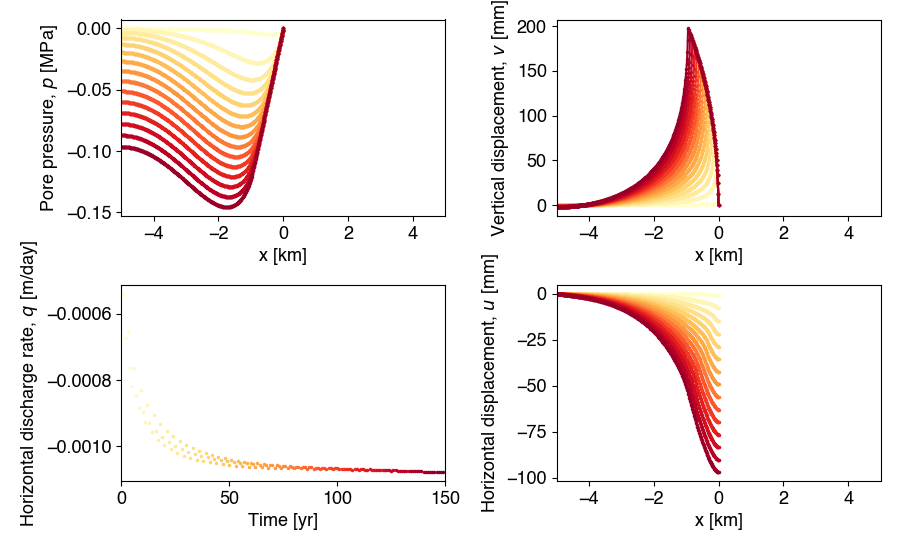

In [3]:
horizontal_diffusion(nx,dx,x,times,dt,nt,gamma,c,sigma_ice,k,mu,B,nu,nu_u,G,alpha)